## Implement paper "Audio Declipping with Social Sparsity"
### Authors: Styliani Douka, Ni Wang
##### Abstract:
##### In this project, we implement the declipping method based on relaxion version of ISTA. Our implementation specifically focus on observing two types of shrinkage algorithm: "Classical Lasso" (L) and "Group Lasso" (WGL). Our code includes three parts: 
##### * Part (1)  implements each function module;
##### * Part (2) tests the feasibility of this algorithm on a speech audio with a specific clipping level by observng SDR improvement and declipped audio graph; 
##### * Part (3) experiments this declipping algorithm with "Lasso" and "Group Lasso" shrinkages with varying clipping percentages (0.2, 0.4, 0.6, 0.8) respectively on two types of audios: speech and music. The optimal reconstructed result is then plotted in audio graph to verify the experiment result.
#### Key findings from this project will be concluded at the end of this notebook.

### Part(1) Implement each function module:
#### Basic setup:

In [1]:
import os
import numpy as np
import scipy.io.wavfile
from scipy.signal import hann
from scipy.signal import get_window
from scipy.fftpack import dct, idct
import IPython
import math
import matplotlib.pyplot as plt
import time
import pickle

#### Necessary function modules:

#### A module to compute the normalized weights 

In [2]:
def weights(fmin, fmax, coef_count, peakfreq, powercoef):
    if peakfreq < fmin or peakfreq > fmax:
        raise ValueError("Peak Frequency must be in the bounds of Fmin and Fmax!")
    f = np.linspace(fmin, fmax, coef_count)
    peakindex = np.abs(f - peakfreq).argmin()
    weights = np.concatenate((np.linspace(0, 1, peakindex) ** powercoef, np.linspace(1, 0, coef_count - peakindex) ** powercoef))
    return weights

#### A module to compute Group-Lasso threshold function

In [3]:
def wgl_thresh(W, lammbda, type):
    M, N = W.shape
    if type == 'time':
        W = np.repeat(np.sqrt(np.sum(W**2, axis=1)), N, axis=0) #axis=1)), N, axis=1)
    elif type == 'freq':
        W = np.repeat(np.sqrt(np.sum(W**2, axis=0)), M, axis=0)

    threshfunc = lammbda / W
    return threshfunc

#### A module to compute Classic-Lasso threshold function

In [4]:
def l_thresh(W, lammbda):
    threshfunc = lammbda / W
    return threshfunc

#### A module to calculate persistent weights which smoothes the data for generating persistent shrinkage masks

In [5]:
def persistent_weights(G, neigh, center):
    # get data
    G = np.atleast_2d(G).T
    M, N = G.shape 
    MM, NN = neigh.shape
    c1, c2 = center
    # take actual centers of neighborhood
    cc1 = np.ceil(MM/2).astype(int) 
    cc2 = np.ceil(NN/2).astype(int)
    # normalize neighborhood weights
    neigh = neigh/np.linalg.norm(neigh.flatten(), 1) 

    # check neighborhood - center point relations
    if center[0] > MM:
        print("Wrong check neighborhood - center point relations!")
        return
    elif center[1] > NN:
        print("Wrong check neighborhood - center point relations!")
        return
    # make larger matrix with mirrowed borders:
    X2 = np.zeros((M+MM-1, N+NN-1)) 
    # put x in the middle of x2
    X2[c1-1: M+c1-1, c2-1: N+c2-1] = np.abs(G)**2 
    # left border
    X2[:, 0:c2-1] = np.fliplr(X2[:, c2-1 : 2*(c2-1)]) 
    # right border
    X2[:, N+c2-1:] = np.fliplr(X2[:, N - NN +2*c2-1: N+c2-1]) 
    # upper border
    X2[0:c1-1, :] = np.flipud(X2[c1-1:2*(c1-1), :]) 
    # lower border
    X2[M+c1-1:, :] = np.flipud(X2[M-MM + 2*c1-1: M+c1-1, :]) 

    # compute the stuff via convolution
    X2 = scipy.signal.convolve2d(X2, neigh, "same")
    # resize matrix 
    W = X2[cc1-1 : M + cc1 - 1, cc2-1 : N + cc2 -1] 
    W = np.sqrt(W) 
    return W

#### A function to compute shrinkage

In [6]:
def gen_thresh(G, shrink):
    # computation of persistence weights
    W = persistent_weights(G, shrink["neigh"], shrink["center"])

    # computation of threshold function values
    if shrink["type"] == "l": # LASSO
        TF = l_thresh(W, shrink["lambda"])
    elif shrink["type"] == "gl": # GROUP-LASSO
        TF = wgl_thresh(W, shrink["lambda"], shrink["glabel"])

    # compute shrinkage
    TF[np.isinf(TF)] = 0
    if "weights" in shrink:
        Gs = 1 - np.multiply(TF**shrink["expo"], shrink["weights"])
    else:    
        Gs = 1 - TF**shrink["expo"]
    GGs = Gs * (Gs > 0)

    if shrink["orth"] == 1:
        M, N = GGs.shape
        MM, NN = shrink["neigh"].shape
        c1 = shrink["center"][0]
        c2 = shrink["center"][1]
        cc1 = (MM+1)//2
        cc2 = (NN+1)//2 # take actual centers of neighborhood
        neigh = shrink["neigh"]/np.linalg.norm(shrink["neigh"].flatten(), 1) # normalize neighborhood weights
        # make larger matrix with mirrowed borders:
        X2 = np.zeros((M+MM-1, N+NN-1)) 
        # put x in the middle of x2
        X2[c1-1: M+c1-1, c2-1: N+c2-1] = GGs 
        # left border
        X2[:, :c2-1] =  np.fliplr(X2[:, c2-1 : 2*(c2-1)]) 
        # right border
        X2[:, N+c2-1:] = np.fliplr(X2[:, N - NN +2*c2-1: N+c2-1])
        # upper border
        X2[:c1-1, :] = np.flipud(X2[c1-1:2*(c1-1), :]) 
        # lower border
        X2[M+c1-1:, :] = np.flipud(X2[M-MM + 2*c1-1: M+c1-1, :]) 

        # compute the stuff via convolution!
        X2 = (scipy.signal.convolve2d(X2, neigh, "same"))
        # resize matrix    
        GGs = X2[cc1-1 : M + cc1 - 1, cc2-1 : N + cc2 -1] 

    GGs = GGs.flatten()
    Gs = np.multiply(G, GGs)
    return Gs

#### Define a module generating clipped signal

In [7]:
norm = lambda x: np.sqrt(np.sum(x**2))
# design a function to calculate SDR
def sdr(or_signal, proc_signal):
    sdr_val = 20*np.log10(norm(or_signal)/norm(or_signal-proc_signal))
    return sdr_val
# hard clip
def hard_clip(signal, tmin, tmax):
    if (min(signal)>=tmin) and (max(signal)<=tmax):
        print(f'Clipping range too large. No clipping will occur')
    if tmin >= tmax: 
        raise(AttributeError(f'Lower clipping level must be smaller than upper one'))

    clipped = signal
    # Initialize the mask
    masks = {}
    masks['Mh'] = (signal > tmax)
    masks['Ml'] = (signal < tmin)
    masks['Mr'] = ~ (masks['Mh'] | masks['Ml'])
    clipped = np.clip(clipped, tmin, tmax)
    return clipped, masks
# a function which generates clipped signal and finds percentage of samples clipped:
def clip_sdr(signal, clipping_percentage):
    # threshold
    data_mean = np.mean(np.abs(signal))
    signal_max = np.max(signal)
    theta = signal_max * clipping_percentage

    # clipping
    clipped, masks = hard_clip(signal, -theta, theta)
    trueSDR = 20 * np.log10(data_mean / theta)
    percentage = 100 * sum(~masks['Mr']) / len(signal)
    return clipped, masks, theta, trueSDR, percentage

### Part(2) Test the feasibility of this algorithm with a specific clipping level:

#### Load audio file

In [8]:
# A function which plots audio graph:
def plot_audio(data, rate):
  size = data.shape[0]
  time = np.linspace(0., size/rate, size)
  plt.plot(time, data)
  plt.xlabel("Time [s]")
  plt.ylabel("Amplitude")
  plt.show()

In [9]:
audio_file = 'speech.wav'
# get sample rate and the data
samplerate, our_data = scipy.io.wavfile.read(audio_file) 
# get the type of data
print(type(our_data))
#print(f"number of channels = {our_data.shape[0]}")
# signal length
print(len(our_data))
Ls = len(our_data)
length = our_data.shape[0] / samplerate
print(f"length = {length}s")
IPython.display.Audio(data=our_data, rate=samplerate)


<class 'numpy.ndarray'>
260343
length = 32.542875s


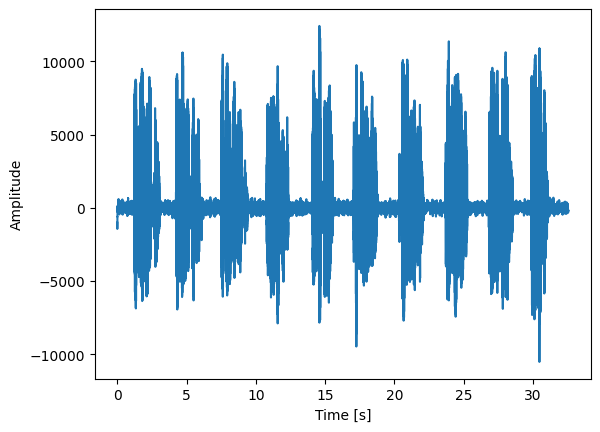

In [10]:
# Have a look at input data:
plot_audio(our_data, samplerate)

### Settings

In [11]:
# Input SDR of the clipped signal
clipping_level = 0.5  # Set the intended clipping level:

# DGT parameters
# window type
wtype = 'hann'  
# window length
w = int(our_data.shape[0]/2)  
# window shift 
a = w // 4  
# number of frequency channels
M = our_data.shape[0]

# Set weighting
# Enable parabola-based weights?
weighting = False 

# set if we want to print detailed information during iterations:
verbose = True

#### Clipping:
#### We compute the theta threshold of the clipping by assigning a clipping level. The clipping level is a percentage of the amplitude of the signal (y axes range). This means that lower clipping levels equivalent more distrortion on the signal as the clipping threshold is lower. For example when we say that the clipping level is 0.2 this means that we clip all the values that are above the 20% of the maximum amplitude of the signal

In [12]:
# Clipping
print('Generating clipped signal..............')
data_clipped, masks, theta, trueSDR, percentage = clip_sdr(our_data, clipping_level)
# Clipping of original signal
print(f'Clipping threshold {theta:.3f}, true SDR value is {trueSDR:.2f} dB and {percentage:.2f}% samples have been clipped')

# Initialize the reconstruction mask:
data_r = np.zeros(Ls)
data_r[masks['Mr']] = data_clipped[masks['Mr']]

# Initialize the mask:
data_c = np.zeros(Ls)
# higher bound of clipping in mask:
data_c[masks['Mh']] = theta
# lower bound of clipping in mask:
data_c[masks['Ml']] = -theta

Generating clipped signal..............
Clipping threshold 6206.000, true SDR value is -17.54 dB and 1.03% samples have been clipped


In [13]:
# Display the clipped signal:
IPython.display.Audio(data=data_clipped, rate=samplerate)

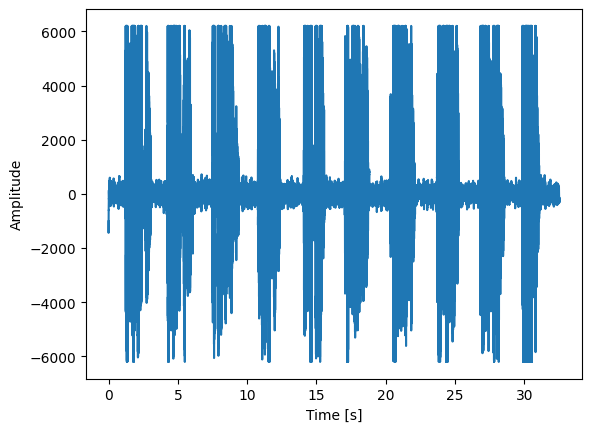

In [14]:
# Have a look at clipped signal graph:
plot_audio(data_clipped, samplerate)

#### Construction of the frame

In [15]:
# Set important arguments in different types of shrinkage:
def set_shrinkage(shrinkage):
    if shrinkage == 'L':
        shrink = {'type': 'l', 
                'lambda': 1e-3, 
                'mu': 1,
                'glabel': 'time', 
                'neigh': np.ones((2,2)), 
                'center': [1, 1], 
                'expo': 1,
                'orth':0}
    elif shrinkage == 'WGL':
        shrink = {'type': 'gl',
                'lambda': 1e-4,
                'mu': 1,
                'glabel': 'time',
                'neigh': np.ones((3, 7)),
                'center': [2, 4],
                'expo': 1,
                'orth': 0}
    elif shrinkage == 'EW':
        shrink = {'type': 'l', 
                'lambda': 1e-4,
                'mu': 1, 
                'glabel': 'time',
                'neigh': np.ones((1,1)),
                'center': [1, 1], 
                'expo': 2,
                'orth':0}
    elif shrinkage == 'PEW':
        shrink = {'type': 'l',
                'lambda': 1e-4, 
                'mu': 1, 
                'glabel': 'time',
                'neigh': np.ones((3,7)), 
                'center': [2,4], 
                'expo': 2,
                'orth':0}
    else:
        print('Invalid shrinkage operator!')
        shrink = None
    return shrink

In [16]:
# set shrinkage operator
shrinkage = 'L'  # 'L', 'WGL', 'EW', 'PEW'
print(f"Setting up shrinkage operator: {shrinkage}")

# construction of the frame
g = hann(w)
G_clip = dct(data_clipped, type=2, n=M, norm='ortho')
# Check the size:
nf = G_clip.shape
print(nf)

def gab_analysis(x):
    return dct(x, type=2, n=M, norm='ortho')

def gab_synthesis(x):
    return idct(x, type=2, n=M, norm='ortho', axis=-1)

Setting up shrinkage operator: L
(260343,)


#### Setting of the Shrinkage operator

In [17]:
shrink = set_shrinkage(shrinkage)
# Construction of weights
if weighting:
    shrink['weights'] = weights(0, samplerate/2, math.floor(M/2)+1, samplerate/2, 2)
shrink

{'type': 'l',
 'lambda': 0.001,
 'mu': 1,
 'glabel': 'time',
 'neigh': array([[1., 1.],
        [1., 1.]]),
 'center': [1, 1],
 'expo': 1,
 'orth': 0}

#### Relaxed version of ISTA

In [18]:
# define declipping method with ISTA algorithm:
def declipping(data_clipped, shrink, number_lambdas, inner_iterations, delta, verbose):
    start_time = time.perf_counter()
    
    # Initialize the loop:
    iter_cnt = 0
    lambda_cnt = 0
    Gdeclip = np.zeros(nf)
    GdeclipZ = Gdeclip

    dSDR_process = np.full((number_lambdas*inner_iterations, 1), np.nan)
    # Initialize reconstructed signal:
    data_rec = data_clipped
    
    for lambda_ in np.logspace(-1, -4, number_lambdas):
        shrink['lambda'] = lambda_
        lambda_cnt += 1
        for k in range(1, inner_iterations + 1):
            
            data_rec_old = data_rec
            iter_cnt += 1
            
            # forward step
            GdeclipOLD = Gdeclip
            
            xdeclipZ = gab_synthesis(GdeclipZ)
            # Initialize r1
            r1 = np.zeros((Ls,)) 
            # find the new value 
            a = data_r[masks['Mr']] - xdeclipZ[masks['Mr']]
            # Allowcate new value in r1
            r1[masks['Mr']] = a
            
            grad1 = -gab_analysis(r1)
            
            # Apply the mask:
            # Initialize r2
            r2 = np.zeros((Ls,))
            r2[masks['Mh']] = data_c[masks['Mh']] - xdeclipZ[masks['Mh']]
            r2[masks['Ml']] = data_c[masks['Ml']] - xdeclipZ[masks['Ml']]
            
            r2[np.abs(xdeclipZ) > theta] = 0
            grad2 = -gab_analysis(r2)
            GdeclipZ = GdeclipZ - grad1 - grad2            
            # thresholding step
            Gdeclip = gen_thresh(GdeclipZ, shrink)            
            # relaxation step
            GdeclipZ = Gdeclip + (k - 1) / (k + 5) * (Gdeclip - GdeclipOLD)
            # Obtain the reconstructed signal:
            data_rec = gab_synthesis(Gdeclip)
            if np.linalg.norm(data_rec_old - data_rec) < delta:
                break
            # calculate the SDR of reconstructed signal compared to original input:
            sdr_rec = sdr(our_data, data_rec)
            if (verbose) and (k%50==0):
                print(f'\r  lambda({lambda_cnt}/{number_lambdas}) = {lambda_} -- it = {k} -- SDR = {sdr_rec}', end='')

    end_time = time.perf_counter()
    # Calculate the time consumed by this method:
    eta = end_time - start_time
    print()
    print(f'ETA: {eta}s')
    print(f'ETA: {eta/60}m')
    return data_rec, sdr_rec

In [19]:
number_lambdas = 15
inner_iterations = 500 
delta = 1e-4

data_rec, sdr_rec = declipping(data_clipped, shrink, number_lambdas, inner_iterations, delta, verbose)

  lambda(6/15) = 0.008483428982440725 -- it = 500 -- SDR = -9.530665311732883
ETA: 407.06197318200066s
ETA: 6.7843662197000105m


#### SDR evaluation

In [20]:
# SDR improvement
sdr_clip = sdr(our_data, data_clipped)
sdr_rec = sdr(our_data, data_rec)
print(f'SDR of the clipped signal is {sdr_clip:.3f} dB.')
print(f'SDR of the reconstructed signal is {sdr_rec:.3f} dB.')
print(f'SDR improvement is {sdr_rec - sdr_clip:.3f} dB.')

SDR of the clipped signal is -10.759 dB.
SDR of the reconstructed signal is -9.531 dB.
SDR improvement is 1.229 dB.


In [21]:
# Load the reconstructed signal:
IPython.display.Audio(data=data_rec, rate=samplerate)

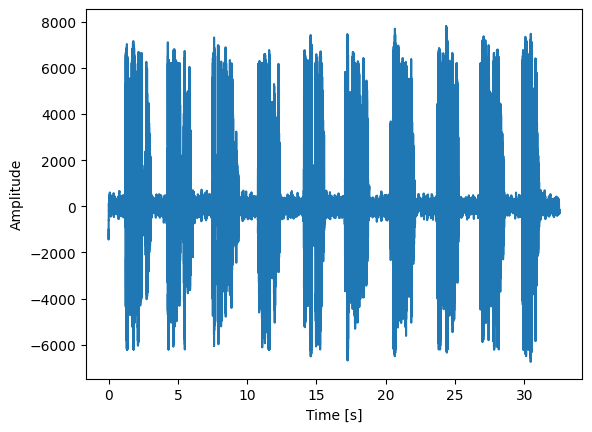

In [22]:
# Plot the graph of reconstruced signal:
plot_audio(data_rec, samplerate)

#### Part(3) Experiment with varying clipping levels (0.2, 0.4, 0.6, 0.8), on music and speech respectively.

In [23]:
# Choose the operators:
operators = ['L', 'WGL']
# Setting hyperparameters:
number_lambdas = 15 
inner_iterations = 500
delta = 1e-4

#### First, experiment with speech signal:

In [25]:
# Initialize the results:
results = np.zeros((len(operators), 4))
# Initialize the index of varying clipping levels:
i = 0
for cl in range(2, 10, 2):
    clip_level = cl/10

    # Clipping of original signal
    data_clipped, masks, theta, trueSDR, percentage = clip_sdr(our_data, clip_level)

    data_r = np.zeros(Ls)
    data_r[masks['Mr']] = data_clipped[masks['Mr']]
    data_c = np.zeros(Ls)
    # Set the higher bound and lower bound of the clipping mask:
    data_c[masks['Mh']] = theta
    data_c[masks['Ml']] = -theta
    
    # implement both L and WGL 
    for op_i in range(len(operators)):
        shrink = set_shrinkage(operators[op_i])

        # Declipping
        print(f'\n[{operators[op_i]}]:Clipping threshold {theta:.3f}, true SDR value is {trueSDR:.2f} dB and {percentage:.2f}% samples have been clipped')
        data_rec, sdr_rec = declipping(data_clipped, shrink, number_lambdas, inner_iterations, delta, True)

        sdr_clip = sdr(our_data, data_clipped)
        results[op_i, i] = sdr_rec - sdr_clip
        with open('sdr_improvement.pkl','wb') as f:
            pickle.dump(results, f)
    i += 1


[L]:Clipping threshold 2482.400, true SDR value is -9.58 dB and 10.54% samples have been clipped
  lambda(13/15) = 0.0002682695795279727 -- it = 500 -- SDR = -23.0772968440618986
ETA: 734.4763051419995s
ETA: 12.241271752366659m

[WGL]:Clipping threshold 2482.400, true SDR value is -9.58 dB and 10.54% samples have been clipped
  lambda(13/15) = 0.0002682695795279727 -- it = 500 -- SDR = -23.1209109253182566
ETA: 1029.6320880069998s
ETA: 17.16053480011666m

[L]:Clipping threshold 4964.800, true SDR value is -15.60 dB and 2.33% samples have been clipped
  lambda(10/15) = 0.0011787686347935879 -- it = 500 -- SDR = -14.394559964650272
ETA: 557.2737925290003s
ETA: 9.287896542150005m

[WGL]:Clipping threshold 4964.800, true SDR value is -15.60 dB and 2.33% samples have been clipped
  lambda(10/15) = 0.0011787686347935879 -- it = 500 -- SDR = -14.366481420506723
ETA: 796.8402685789988s
ETA: 13.280671142983314m

[L]:Clipping threshold 7447.200, true SDR value is -19.12 dB and 0.42% samples hav

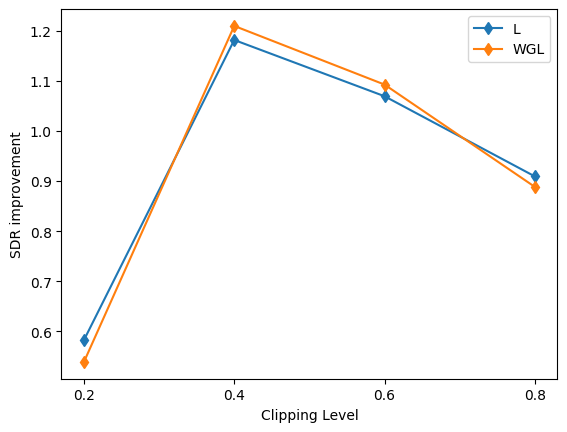

In [26]:
# Plot SDR improvements associated with varying clipping levels:
plt.figure()
for i in range(len(operators)):
    plt.plot(results[i], label=operators[i], marker='d')
plt.xticks(range(4), map(lambda x: x/10, list(range(2,10,2))))
plt.xlabel('Clipping Level')
plt.ylabel('SDR improvement')
plt.legend()
plt.show()

In [27]:
# Save the results:
with open('sdr_improvement.pkl','wb') as f:
    pickle.dump(results, f)

In [28]:
with open('sdr_improvement.pkl', 'rb') as f:
  results = pickle.load(f)
print(results)

[[0.58264923 1.18161911 1.06933879 0.9093272 ]
 [0.53903513 1.20969747 1.09258153 0.8884031 ]]


#### Then, change the input signal to a music:

In [36]:
# Load a music:
audio_file = 'music.wav'
samplerate, our_data = scipy.io.wavfile.read(audio_file) 
# Update constants:
Ls = len(our_data)
w = int(our_data.shape[0]/2)  
# window shift 
a = w // 4  
# number of frequency channels
M = our_data.shape[0]
# construction of the frame
g = hann(w)
G_clip = dct(data_clipped, type=2, n=M, norm='ortho')
# Check the size:
nf = G_clip.shape


[L]:Clipping threshold 2471.600, true SDR value is -2.14 dB and 30.27% samples have been clipped
  lambda(15/15) = 0.0001 -- it = 500 -- SDR = -32.951318071281115.951464674486424
ETA: 1021.4337382570011s
ETA: 17.023895637616686m

[WGL]:Clipping threshold 2471.600, true SDR value is -2.14 dB and 30.27% samples have been clipped
  lambda(15/15) = 0.0001 -- it = 500 -- SDR = -33.047990037226795.048122649630235
ETA: 1400.4751097619992s
ETA: 23.34125182936665m

[L]:Clipping threshold 4943.200, true SDR value is -8.16 dB and 9.69% samples have been clipped
  lambda(15/15) = 0.0001 -- it = 500 -- SDR = -24.207251767380744.207604561108003
ETA: 893.1964039429986s
ETA: 14.88660673238331m

[WGL]:Clipping threshold 4943.200, true SDR value is -8.16 dB and 9.69% samples have been clipped
  lambda(15/15) = 0.0001 -- it = 500 -- SDR = -24.254580874697815.254943308954612
ETA: 1427.2997887569982s
ETA: 23.788329812616634m

[L]:Clipping threshold 7414.800, true SDR value is -11.68 dB and 1.78% samples h

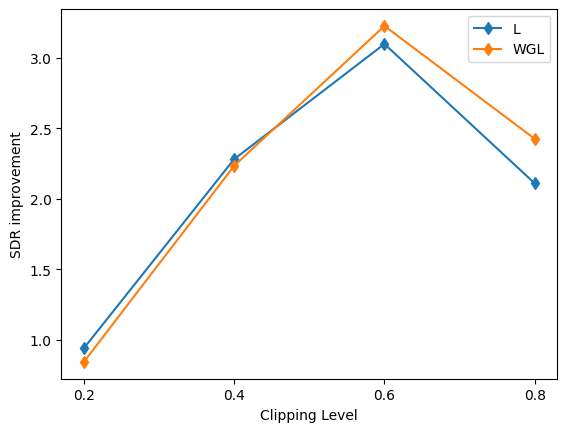

In [37]:
# Initialize the results:
results = np.zeros((len(operators), 4))
# Initialize the index of varying clipping levels:
i = 0
for cl in range(2, 10, 2):
    clip_level = cl/10

    # Clipping of original signal
    data_clipped, masks, theta, trueSDR, percentage = clip_sdr(our_data, clip_level)

    data_r = np.zeros(Ls)
    data_r[masks['Mr']] = data_clipped[masks['Mr']]
    data_c = np.zeros(Ls)
    # Set the higher bound and lower bound of the clipping mask:
    data_c[masks['Mh']] = theta
    data_c[masks['Ml']] = -theta
    
    # implement both L and WGL 
    for op_i in range(len(operators)):
        shrink = set_shrinkage(operators[op_i])

        # Declipping
        print(f'\n[{operators[op_i]}]:Clipping threshold {theta:.3f}, true SDR value is {trueSDR:.2f} dB and {percentage:.2f}% samples have been clipped')
        data_rec, sdr_rec = declipping(data_clipped, shrink, number_lambdas, inner_iterations, delta, True)

        sdr_clip = sdr(our_data, data_clipped)
        results[op_i, i] = sdr_rec - sdr_clip
        with open('sdr_improvement.pkl','wb') as f:
            pickle.dump(results, f)
    i += 1
    
# Plot SDR improvements associated with varying clipping levels:
plt.figure()
for i in range(len(operators)):
    plt.plot(results[i], label=operators[i], marker='d')
plt.xticks(range(4), map(lambda x: x/10, list(range(2,10,2))))
plt.xlabel('Clipping Level')
plt.ylabel('SDR improvement')
plt.legend()
plt.show()    

#### Plot the clipped and reconstructed audio graph with peak SDR improvement (SNR miss) to verify experiment result, where shrinkage type is 'WGL' and clipping level is 0.6.

In [45]:
# Load the original signal:
IPython.display.Audio(data=our_data, rate=samplerate)

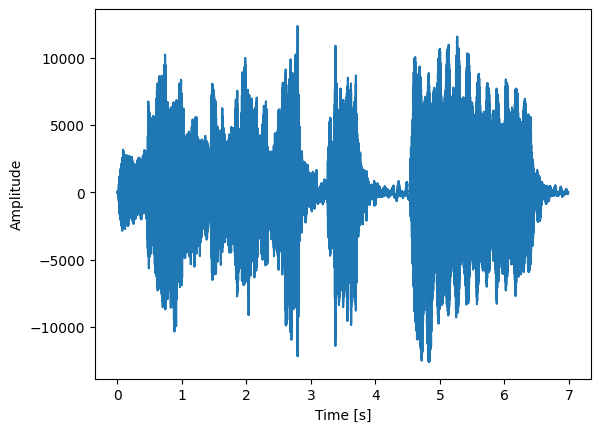

In [46]:
plot_audio(our_data, samplerate)

In [53]:
# Clipping
# Initialize the mask:
# define optimal clipping level according to the SDR Improvement - clipping level graph above:
optimal_clipping_level = 0.6
clipping_level = optimal_clipping_level
data_clipped, masks, theta, trueSDR, percentage = clip_sdr(our_data, clipping_level)
data_c = np.zeros(Ls)
# higher bound of clipping in mask:
data_c[masks['Mh']] = theta
# lower bound of clipping in mask:
data_c[masks['Ml']] = -theta
print('Generating clipped signal..............')

# Clipping of original signal
print(f'Clipping threshold {theta:.3f}, true SDR value is {trueSDR:.2f} dB and {percentage:.2f}% samples have been clipped')
IPython.display.Audio(data=data_clipped, rate=samplerate)

Generating clipped signal..............
Clipping threshold 7414.800, true SDR value is -11.68 dB and 1.78% samples have been clipped


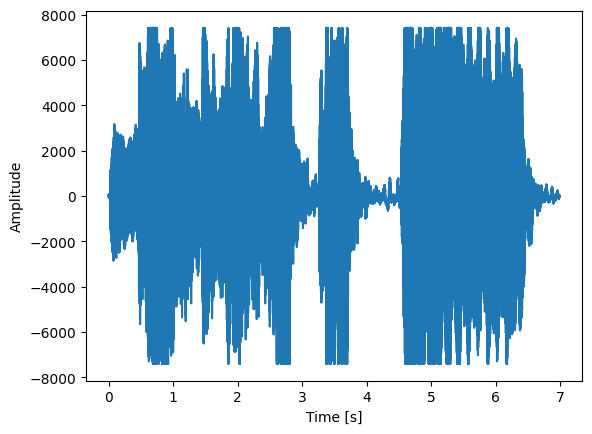

In [54]:
plot_audio(data_clipped, samplerate)

In [55]:
# Declipping:
# Now shrink = 'WGL' due to the result of last implementation
# Initialize the reconstruction mask:
data_r = np.zeros(Ls)
data_r[masks['Mr']] = data_clipped[masks['Mr']]
data_rec, sdr_rec = declipping(data_clipped, shrink, number_lambdas, inner_iterations, delta, verbose = False)
# SDR improvement
sdr_clip = sdr(our_data, data_clipped)
sdr_rec = sdr(our_data, data_rec)
print(f'SDR of the clipped signal is {sdr_clip:.3f} dB.')
print(f'SDR of the reconstructed signal is {sdr_rec:.3f} dB.')
print(f'SDR improvement is {sdr_rec - sdr_clip:.3f} dB.')
# Load the reconstructed signal:
IPython.display.Audio(data=data_rec, rate=samplerate)


ETA: 2183.176727068996s
ETA: 36.38627878448327m
SDR of the clipped signal is -17.144 dB.
SDR of the reconstructed signal is -13.920 dB.
SDR improvement is 3.224 dB.


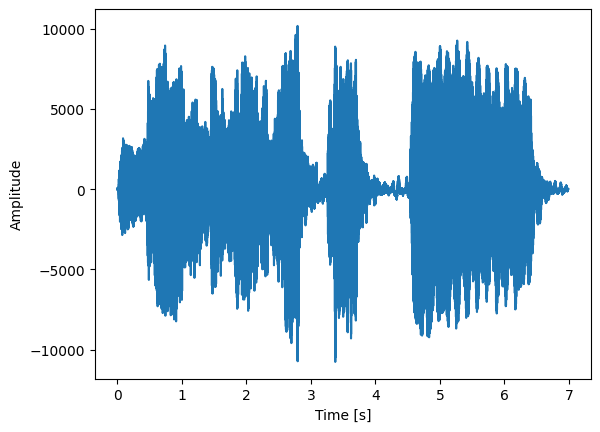

In [56]:
# Plot the graph of reconstruced signal:
plot_audio(data_rec, samplerate)

#### Conclusions:
#### The shrinkage algorithms that we implemented, Lasso and Group-Lasso, have similar results to that of the paper. Not a single shrinkage algorithm of the two performs better every time, but we could say that they are comparable depending on the clipping level. In general WGL performs better in higher clipping levels, which means resulting in a reconstructed audio signal with less distortion. This algorithm is also found to perform slightly differently on speech (up to 1.17 dB with 'L' and 1.2 dB with 'WGL') and music (up to 3.180 dB with 'L' and 3.224 dB with 'WGL') with different clipping levels at which the peaks appear.